## Resnet34 using Fastai library

Lastly, we trained a resnet34 with the full dataset. Took about 0.5 hour and attained a 99.4% accuracy.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Size was changed to 224, instead of 150 in Chollet's Chapter 5.

In [4]:
PATH = "data/dogscats/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

Make sure source file directory has the following structure.

In [5]:
os.listdir(PATH)

['models', 'test1', 'sample', 'tmp', 'valid', 'train']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
os.listdir(f'{PATH}valid/cats')[:5]

['cat.2522.jpg',
 'cat.4237.jpg',
 'cat.2469.jpg',
 'cat.2584.jpg',
 'cat.6601.jpg']

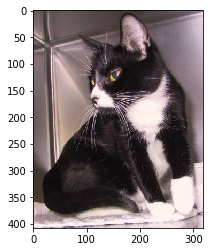

In [10]:
def get_cat(file):
    image = os.listdir(f'{PATH}valid/cats')[file]
    img = os.path.join(f'{PATH}valid/cats',image )
    img1 = plt.imread(img)
    return plt.imshow(img1)

get_cat(0)    

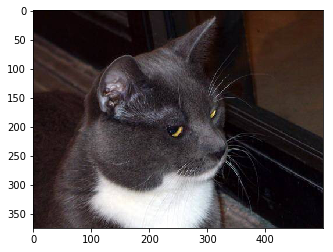

In [11]:
get_cat(1) 

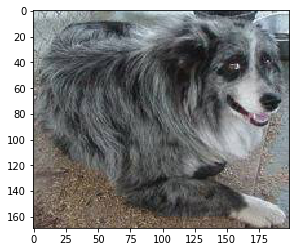

In [12]:
def get_dog(file):
    image = os.listdir(f'{PATH}valid/dogs')[file]
    img = os.path.join(f'{PATH}valid/dogs',image )
    img1 = plt.imread(img)
    return plt.imshow(img1)

get_dog(0)

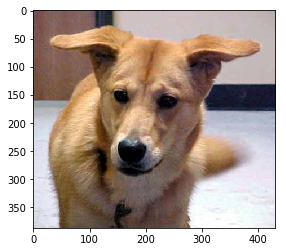

In [13]:
get_dog(1)

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049949   0.029696   0.9895    
    1      0.034624   0.029067   0.9885                       



[array([0.02907]), 0.9885]

In [15]:
data.classes

['cats', 'dogs']

In [16]:
learn.save('Q_resnet_fastai_precompute_full_dataset.h5') 

In [17]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.00043,  -7.74889],
       [ -0.00001, -11.93153],
       [ -0.00602,  -5.11484],
       [ -0.00022,  -8.43808],
       [ -0.00013,  -8.95063],
       [ -0.00006,  -9.68394],
       [ -2.14861,  -0.12403],
       [ -0.0061 ,  -5.10226],
       [ -0.00032,  -8.05864],
       [ -0.00004, -10.00802]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [21]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [22]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [23]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


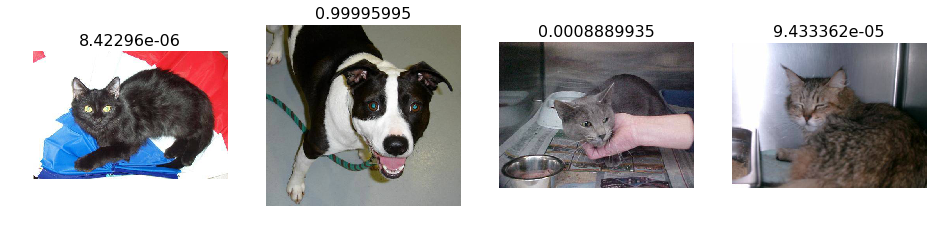

In [24]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


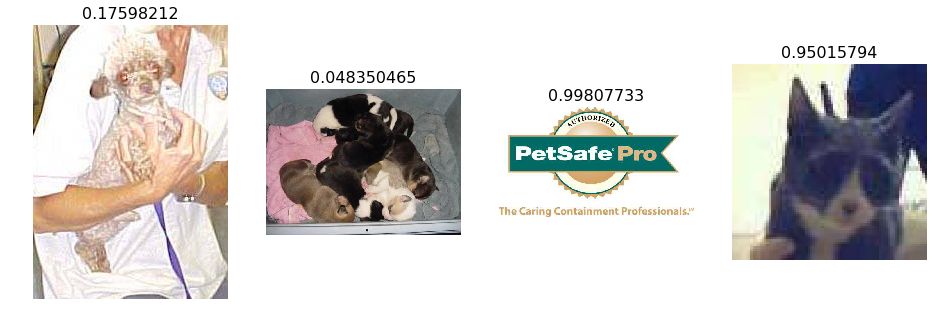

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


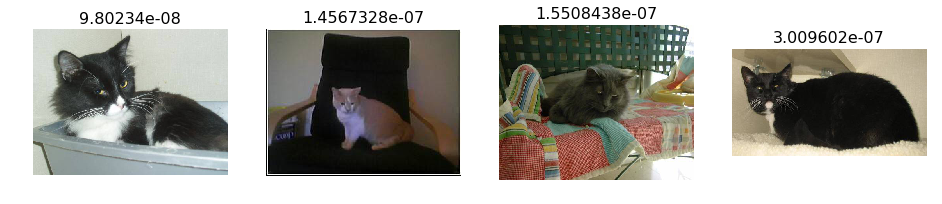

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


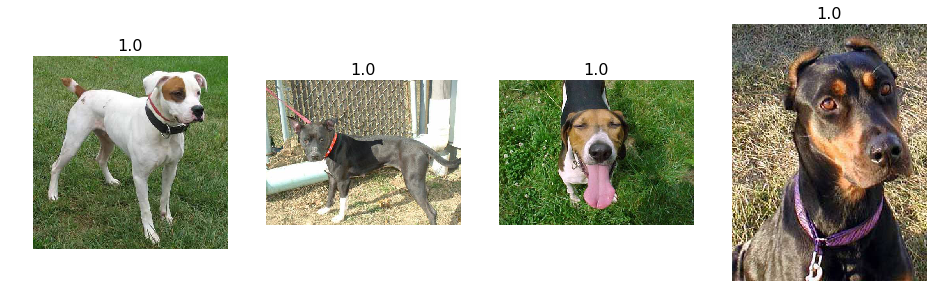

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


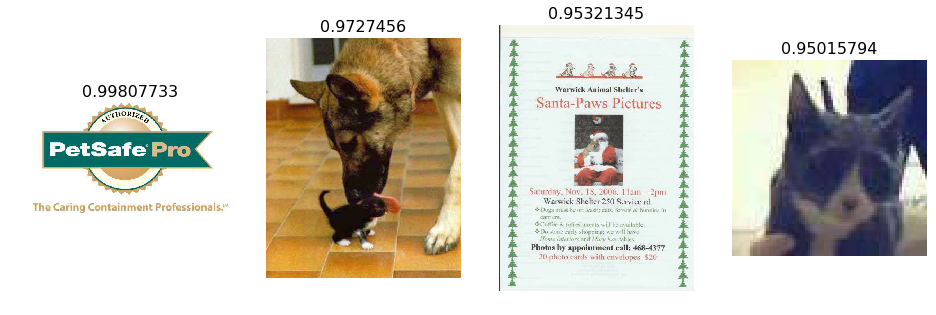

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


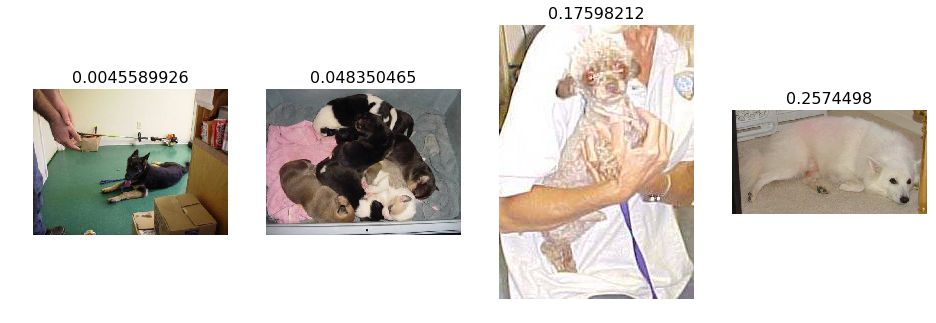

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


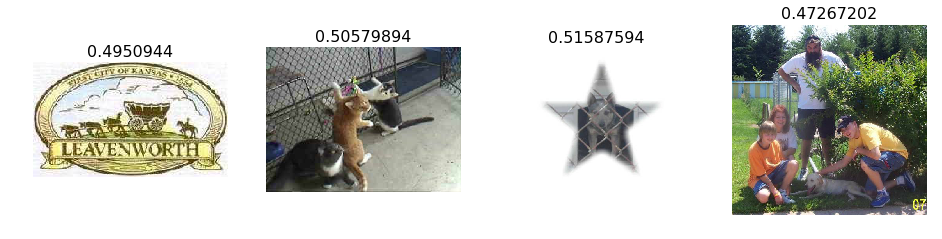

In [31]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()

 83%|████████▎ | 299/360 [00:04<00:00, 67.02it/s, loss=0.308] 


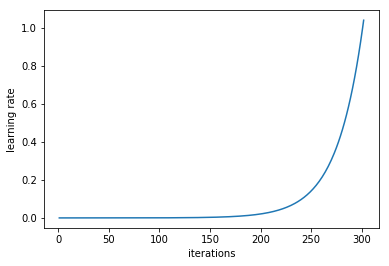

In [34]:
learn.sched.plot_lr()

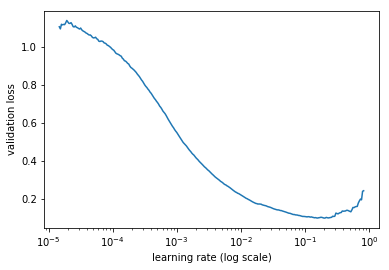

In [35]:
learn.sched.plot()

From the plot, **5e-3** seems like a good learningrate to use

In [36]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

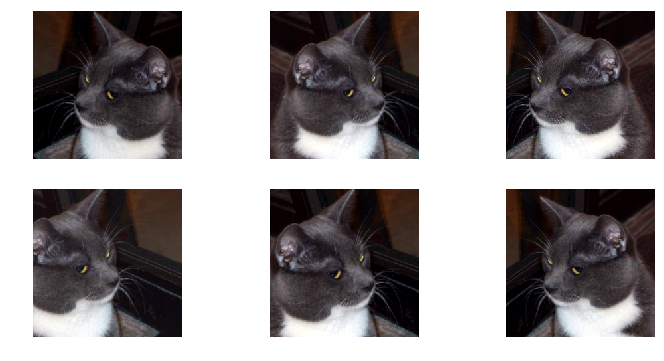

In [39]:
plots(ims, rows=2)

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
learn.fit(5e-3, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04748    0.02886    0.99      



[array([0.02886]), 0.99]

In [41]:
learn.precompute=False

In [42]:
learn.fit(5e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.046807   0.028156   0.989     
    1      0.047276   0.027217   0.9905                       
    2      0.039474   0.02666    0.991                        



[array([0.02666]), 0.991]

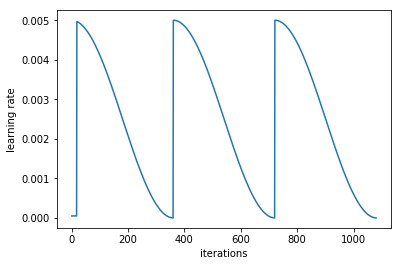

In [43]:
learn.sched.plot_lr()

In [44]:
learn.save('Q_resnet34_fastai_full_dataset.h5') 

In [45]:
learn.load('Q_resnet34_fastai_full_dataset.h5')

### Fine-tuning and differential learning rate annealing

In [46]:
learn.unfreeze()

In [47]:
lr=np.array([5e-5,5e-4,5e-3])

In [48]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.064158   0.031386   0.9905    
    1      0.040984   0.025114   0.991                        
    2      0.033733   0.023508   0.9905                       
    3      0.037237   0.020783   0.9935                       
    4      0.026504   0.021924   0.9915                       
    5      0.024465   0.020771   0.9925                       
    6      0.019287   0.020995   0.9925                       



[array([0.021]), 0.9925]

In [58]:
learn.save('Q_resnet34_fastai_full_dataset.h5') 

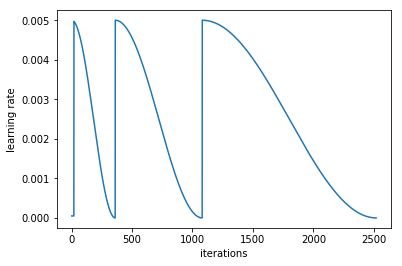

In [49]:
learn.sched.plot_lr()

In [51]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [52]:
accuracy_np(probs, y)

0.994

We attained accuracy of **99.4%** on the test set.

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)

In [53]:
probs = probs[:,1]

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[997   3]
 [  9 991]]


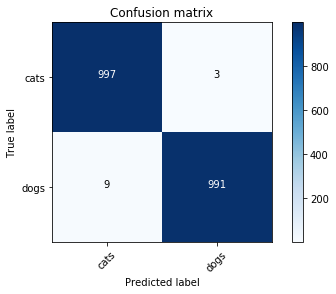

In [55]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


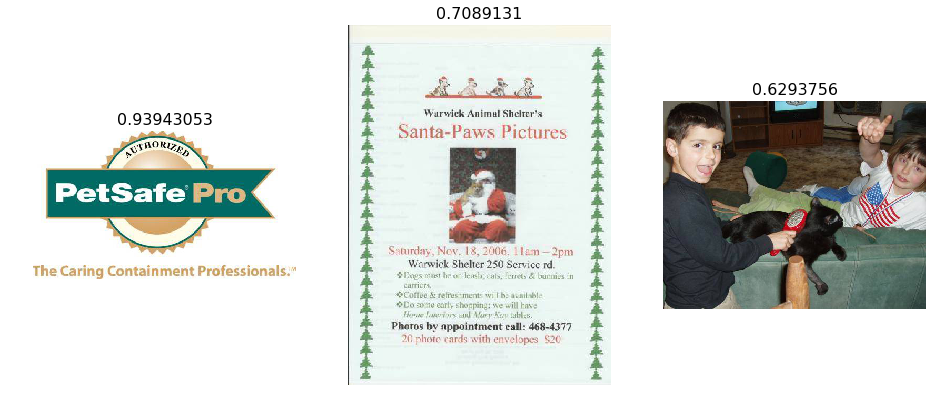

In [56]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


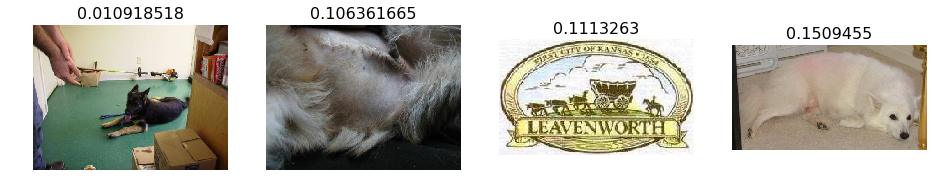

In [57]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")